# Importing the Core Libraries for Start 

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

# All outputs are visible
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Retina resolution for the plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# All plots contained in the notebook
%matplotlib inline

## File Information

* train.csv : the training set describing which tracks are included in the playlists
* tracks.csv : supplementary information about tracks
* target_playlists.csv : the set of target playlists that will receive recommendations

### Target Playlists
* playlist_id : identifier of the playlist that will receive recommendations. The file contains a list of 10k playlists.

* The first 5k target playlists (from playlist_id=7 to playlist_id=50431) are sequential. For each of these playlists, the order of tracks in train.csv corresponds to the order inside the playlist.

* The last 5k target playlists (from playlist_id=3 to playlist_id=50424) are random. For each of these playlists, the order of tracks in train.csv is random and does not generally corresponds to the order inside the playlist. The same is for all other playlists in train.csv.

### Import the Files to the Notebook

In [2]:

trainData = pd.read_csv("../data/train.csv")
trackData = pd.read_csv("../data/tracks.csv")
tP = pd.read_csv("../data/target_playlists.csv")
sS = pd.read_csv("../data/sample_submission.csv")


In [3]:
def getSongs(data,p_id):
    return np.array(data[data['playlist_id'] == p_id]['track_id'])

### General info about the Train data

In [4]:
trainData.shape
trainData.head()
trainData.dtypes

(1211791, 2)

,playlist_id,track_id
0,0,14301
1,0,8360
2,0,12844
3,0,18397
4,0,1220


playlist_id    int64
track_id       int64
dtype: object

### General info about the Track data

In [5]:
trackData.shape
trackData.head()
trackData.dtypes

(20635, 4)

,track_id,album_id,artist_id,duration_sec
0,0,6306,449,167
1,1,12085,4903,185
2,2,1885,6358,201
3,3,3989,1150,263
4,4,11633,4447,96


track_id        int64
album_id        int64
artist_id       int64
duration_sec    int64
dtype: object

In [7]:
# Find how many songs each album contains
trackData['album_counts'] = trackData.groupby('album_id')['album_id'].transform(pd.Series.value_counts)
dfAlbum = pd.DataFrame(data=trackData.loc[:,['album_id','album_counts']])
dfAlbum = dfAlbum.sort_values('album_counts',ascending=False)

# Unique Album List
albumUnique = dfAlbum.drop_duplicates(subset='album_id').reset_index().rename(columns={'index':'track_id'})

# Number of Unique Albums
numAlbums = len(albumUnique)

# Find how many songs each artist has
trackData['artist_counts'] =trackData.groupby('album_id')['album_id'].transform(pd.Series.value_counts)
dfArtist = pd.DataFrame(data=trackData.loc[:,['artist_id','artist_counts']])
dfArtist = dfArtist.sort_values('artist_counts',ascending=False)
# Unique Artist List
artistUnique = dfArtist.drop_duplicates(subset='artist_id').reset_index().rename(columns={'index':'track_id'})
# Number of Unique Artists
numArtists = len(artistUnique)

In [8]:
print("Number of unique albums: {0}".format(numAlbums))
print("Number of unique artists: {0}".format(numArtists))
print("Album with the most number of songs is: {0} with {1} songs".format(albumUnique.loc[0,'album_id'],albumUnique.loc[0,'album_counts']))
print("Artist with the most number of songs is: {0} with {1} songs".format(artistUnique.loc[0,'artist_id'],artistUnique.loc[0,'artist_counts']))

Number of unique albums: 12744
Number of unique artists: 6668
Album with the most number of songs is: 6622 with 28 songs
Artist with the most number of songs is: 2351 with 28 songs


In [9]:
# Find how many users(Playlists) are there
trainData['track_count'] = trainData.groupby('playlist_id')['playlist_id'].transform(pd.Series.value_counts)
dfPlaylist = pd.DataFrame(data=trainData.loc[:,['playlist_id','track_count']])
dfPlaylist = dfPlaylist.sort_values('track_count',ascending=False)
playlists = dfPlaylist.drop_duplicates(subset='playlist_id').reset_index().rename(columns={'index':'interaction_id'})


In [10]:
playlists.head()
playlists.shape

,interaction_id,playlist_id,track_count
0,920407,38239,100
1,1166577,48541,93
2,1063161,44196,93
3,642179,26714,92
4,387764,16146,92


(50446, 3)

In [11]:
tracks = trackData['track_id'].values.reshape(len(trackData['track_id']),1)
playlists2 = playlists['playlist_id'].values.reshape(len(playlists['playlist_id']),1)
tracks.shape
tracks

(20635, 1)

array([[    0],
       [    1],
       [    2],
       ...,
       [20632],
       [20633],
       [20634]])

In [12]:
playlists.shape
playlists.head()

(50446, 3)

,interaction_id,playlist_id,track_count
0,920407,38239,100
1,1166577,48541,93
2,1063161,44196,93
3,642179,26714,92
4,387764,16146,92


In [25]:
 row = np.zeros((20635,1),dtype=int)

songCount = np.array(trainData[trainData['playlist_id'] == 6602]['track_id'])
row[songCount] = 1
playlistRatings = pd.DataFrame(data=np.zeros((playlists['playlist_id'].shape[0],tracks.shape[0])))
for playlist_id in playlists['playlist_id']:
    songCount = np.array(trainData[trainData['playlist_id'] == playlist_id]['track_id'])
    playlistRatings.loc[playlist_id,:][songCount] = 1
    


,0,1,2,3,4,5,6,7,8,9,...,20625,20626,20627,20628,20629,20630,20631,20632,20633,20634
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
playlistRatings.mean(axis=1)

0        0.000242
1        0.001938
2        0.000678
3        0.000485
4        0.002665
5        0.000388
6        0.001454
7        0.001696
8        0.001115
9        0.001066
10       0.000824
11       0.002520
12       0.000291
13       0.001018
14       0.002084
15       0.000775
16       0.000242
17       0.001938
18       0.000533
19       0.000678
20       0.000582
21       0.000339
22       0.000485
23       0.002229
24       0.000630
25       0.000824
26       0.000242
27       0.000339
28       0.000872
29       0.001115
           ...   
50416    0.001599
50417    0.000533
50418    0.000727
50419    0.001454
50420    0.000339
50421    0.001357
50422    0.000388
50423    0.000630
50424    0.002714
50425    0.000242
50426    0.000388
50427    0.000872
50428    0.000436
50429    0.000824
50430    0.000921
50431    0.000436
50432    0.001502
50433    0.002617
50434    0.000485
50435    0.002568
50436    0.000582
50437    0.003005
50438    0.002714
50439    0.000436
50440    0

In [17]:
plr2 = pd.DataFrame(data=np.zeros((playlists['playlist_id'].shape[0],tracks.shape[0])))
plr2.loc[playlists['playlist_id'],:][np.array(trainData[trainData['playlist_id'] == playlist_id]['track_id'])] = 1

(50446, 20635)

In [13]:
playlistColumn = pd.DataFrame(data=trainData['playlist_id'])
trackColumn = pd.DataFrame(data=trainData['track_id'])
# User Equivalent
numPlaylist = len(playlists['playlist_id'])
# Item Equivalent
numTrack = len(trackData['track_id'])
numInteractions = len(trainData)

print ("Number of items\t {}, Number of users\t {}".format(numTrack,numPlaylist))
print ("Average interactions per user {:.2f}".format(numInteractions/numPlaylist))
print ("Average interactions per item {:.2f}\n".format(numInteractions/numTrack))

print ("Sparsity {:.2f} %".format((1-float(numInteractions)/(numTrack*numPlaylist))*100))

Number of items	 20635, Number of users	 50446
Average interactions per user 24.02
Average interactions per item 58.73

Sparsity 99.88 %


In [14]:
trainData['rating'] = list(zip(trainData['playlist_id'],trainData['track_id']))

### General info about the Target Playlists

Seperating the sequential and random ordered playlists

In [15]:
tPSeq = tP.iloc[0:5000]
tPRand = tP.iloc[5000:]

### Seperate the columns of the interactions as Tuples

In [16]:
interactionColumn = np.array(trainData['track_id'])
playlistColumn =  np.array(playlistColumn).flatten()
trackColumn = np.array(trackColumn).flatten()

In [17]:
import scipy.sparse as sps
URM_all = sps.coo_matrix((interactionColumn,(playlistColumn,trackColumn)))
URM_all

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 1211791 stored elements in COOrdinate format>

In [18]:
URM_all.tocsr()

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 1211791 stored elements in Compressed Sparse Row format>

In [20]:
itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity.shape

(1, 20635)

In [21]:
itemPopularity = np.sort(itemPopularity)
itemPopularity

matrix([[   0,    1,    1, ..., 1666, 1725, 1785]], dtype=int64)

Text(0, 0.5, 'Num Interactions ')

Text(0.5, 0, 'User Index')

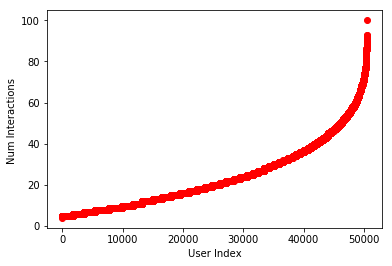

In [22]:
userActivity = (URM_all>0).sum(axis=1)
userActivity = np.array(userActivity).squeeze()
userActivity = np.sort(userActivity)


plt.plot(userActivity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('User Index')
plt.show()

In [53]:
train_test_split = 0.80
numInteractions = URM_all.nnz
train_mask = np.random.choice([True,False], numInteractions, p=[train_test_split, 1-train_test_split])
train_mask

URM_train = sps.coo_matrix((interactionColumn[train_mask], (playlistColumn[train_mask], trackColumn[train_mask])))
URM_train = URM_train.tocsr()
URM_train

array([False,  True, False, ...,  True,  True,  True])

<50446x20635 sparse matrix of type '<class 'numpy.int64'>'
	with 969719 stored elements in Compressed Sparse Row format>

In [54]:
test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((interactionColumn[test_mask], (playlistColumn[test_mask], trackColumn[test_mask])))
URM_test = URM_test.tocsr()
URM_test

<50446x20634 sparse matrix of type '<class 'numpy.int64'>'
	with 242072 stored elements in Compressed Sparse Row format>

In [55]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popularItems[0:at]

        return recommended_items


In [56]:
def precision(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant) 
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]  
    return recall_score

def MAP(recommended_items, relevant_items): 
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True) 
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))  
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])
    return map_score

In [57]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for playlist_id in playlists2:

        relevant_items = URM_test[playlist_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(playlist_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 



In [58]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [59]:
for user_id in playlists2[0:10]:
    print(topPopRecommender.recommend(user_id, at=10))

[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]
[ 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266]


In [60]:
evaluate_algorithm(URM_test, topPopRecommender, at=10)

Recommender performance is: Precision = 0.0062, Recall = 0.0106, MAP = 0.0037


In [61]:
class TopPopRecommender2(object):

    def fit(self, URM_train): 
        self.URM_train = URM_train
        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()
        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    def recommend(self, user_id, at=10, remove_seen=True):
        if remove_seen:
            unseen_items_mask = np.in1d(self.popularItems, self.URM_train[playlist_id].indices,
                                        assume_unique=True, invert = True)
            unseen_items = self.popularItems[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.popularItems[0:at]
            
        return str(recommended_items).strip("[]")

In [65]:
topPopRecommender_removeSeen = TopPopRecommender2()
topPopRecommender_removeSeen.fit(URM_train)

for playlist_id in tP['playlist_id'][0:10]:
    print(topPopRecommender_removeSeen.recommend(playlist_id, at=10))

 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 17239  2674 13980  2272 18266 14758
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266
 8956 10848  5606 15578  2674 13980  2272 18266 14758  1111
 8956 10848  5606 15578 10496 17239  2674 13980  2272 18266


In [66]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen,at=10)

Recommender performance is: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


In [67]:
f= open("submission2.csv","w+")
f.write("playlist_id,track_ids\n")
for ind,playlist_id in enumerate(tP['playlist_id']):
    f.write(str(playlist_id) + ','+ topPopRecommender_removeSeen.recommend(playlist_id,at=10) + '\n');
f.close();

In [68]:
globalAverage = np.mean(URM_train.data)

print("The global average is {:.2f}".format(globalAverage))

The global average is 10358.02


In [70]:
URM_train_unbiased = URM_train.copy()
URM_train_unbiased.data -= globalAverage
print(URM_train_unbiased.data[0:10])

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [37]:
item_mean_rating = URM_train_unbiased.mean(axis=0)
item_mean_rating

matrix([[-4.31231416, -8.41846727, -7.80172858, ..., 19.7534195 ,
          1.01831662,  0.40736629]])

Text(0, 0.5, 'Item Bias')

Text(0.5, 0, 'Item Index')

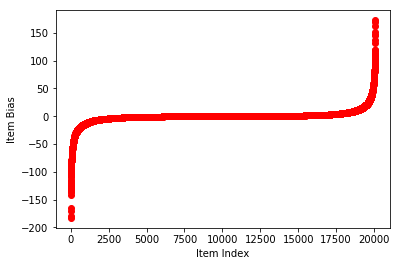

In [38]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating!=0])

plt.plot(item_mean_rating, 'ro')
plt.ylabel('Item Bias')
plt.xlabel('Item Index')
plt.show()

In [39]:
user_mean_rating = URM_train_unbiased.mean(axis=1)
user_mean_rating

matrix([[-0.13142719],
        [ 2.48209353],
        [-0.86329053],
        ...,
        [ 0.24729828],
        [ 1.10680882],
        [-2.52028108]])

Text(0, 0.5, 'User Bias')

Text(0.5, 0, 'User Index')

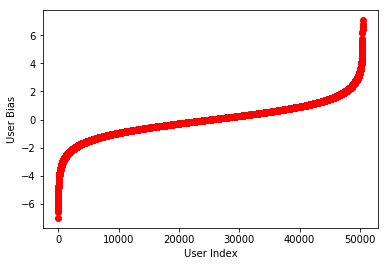

In [40]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

plt.plot(user_mean_rating, 'ro')
plt.ylabel('User Bias')
plt.xlabel('User Index')
plt.show()

In [46]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):  
        self.URM_train = URM_train
        globalAverage = np.mean(URM_train.data)
        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= int(globalAverage)
        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()
        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            unseen_items_mask = np.in1d(self.bestRatedItems, URM_train[playlist_id].indices,
                                        assume_unique=True, invert = True)
            unseen_items = self.bestRatedItems[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.bestRatedItems[0:at]

        return str(recommended_items).strip("[]")

In [47]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


In [ ]:
f= open("submission3.csv","w+")
f.write("playlist_id,track_ids\n")
for ind,playlist_id in enumerate(tP['playlist_id']):
    f.write(str(playlist_id) + ','+ GlobalEffectsRecommender.recommend(playlist_id,at=10) + '\n');
f.close();